# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Exercise-8.2.--Encoding-data" data-toc-modified-id="Exercise-8.2.--Encoding-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exercise 8.2.  Encoding data</a></div><div class="lev1 toc-item"><a href="#Exercise-8.4.-Nonconvexity-of-the-linear-Autoencoder" data-toc-modified-id="Exercise-8.4.-Nonconvexity-of-the-linear-Autoencoder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercise 8.4. Nonconvexity of the linear Autoencoder</a></div><div class="lev1 toc-item"><a href="#Exercise-8.5.-Minimizing-the-linear-Autoencoder-over-a-toy-dataset" data-toc-modified-id="Exercise-8.5.-Minimizing-the-linear-Autoencoder-over-a-toy-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercise 8.5. Minimizing the linear Autoencoder over a toy dataset</a></div><div class="lev1 toc-item"><a href="#Exercise-8.6.-Producing-a-PCA-basis" data-toc-modified-id="Exercise-8.6.-Producing-a-PCA-basis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercise 8.6. Producing a PCA basis</a></div><div class="lev1 toc-item"><a href="#Exercise-8.7.-A-warning-example" data-toc-modified-id="Exercise-8.7.-A-warning-example-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exercise 8.7. A warning example</a></div><div class="lev1 toc-item"><a href="#Exercise-8.8.-Perform-K-Means" data-toc-modified-id="Exercise-8.8.-Perform-K-Means-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exercise 8.8. Perform K-Means</a></div><div class="lev1 toc-item"><a href="#Exercise-8.9.-Making-a-scree-plot" data-toc-modified-id="Exercise-8.9.-Making-a-scree-plot-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Exercise 8.9. Making a scree plot</a></div>

In [3]:
# import autograd-wrapped numpy
import autograd.numpy as np

# datapath to data
datapath = '../mlrefined_datasets/unsuperlearn_datasets/'

# Exercise 8.2.  Encoding data

In [4]:
# load in dataset
import jax
import jax.numpy as jnp
import numpy as np
from jax import grad
import matplotlib.pyplot as plt


csvname = datapath + '2d_span_data.csv'
x = np.loadtxt(csvname, delimiter = ',')


class Solution_Decoder:
    def __init__(self, Cmatrix, x):
        self.C = jnp.array(Cmatrix)
        self.x = jnp.array(x)
        self.w0 = jnp.array(np.random.uniform(low=-5, high=5, size=np.shape(x)))
        self.w = None

    def MSE(self, w):
        return jnp.mean(jnp.linalg.norm(self.decode(w) - self.x, axis=0)**2)
        

    def decode(self, w):
        return jnp.dot(self.C, w)

    def solve_MSE(self):
        self.w = jnp.linalg.solve(jnp.dot(self.C.T, self.C), jnp.dot(self.C.T, self.x))

    def RMSProp(self, d, iter, gamma, loss=False, decreased=False):
        """
        Root Mean Squared Error Propogation - RMSProp
        
        """
        fun = self.MSE
        gradient = grad(fun)
        w0 = jnp.array(self.w0)
        w_history = [w0]
        fun_history = [float(fun(w0))]
        w = w0
        for i in range(iter):
            grad_eval = gradient(w)
            if i > 0:
                h = gamma*h + (1 - gamma)*jnp.square(grad_eval)
            else:
                h = jnp.square(grad_eval)
            
            diff = d*grad_eval/jnp.sqrt(h)
            if decreased:
                diff = diff*(1 / (i + 1))
            w = w - diff
            f = fun(w)
            f = float(f)
            w_history.append(w)
            fun_history.append(f)

        self.w = w
        self.w_history = w_history
    
        if loss:
            Solution_Decoder.build_history_of_loss(iter, fun_history, "RMSProp")
    
        return {"min": (w, f), "weights_history": w_history, "cost_history": fun_history, "iters": iter}

        
    @staticmethod
    def build_history_of_loss(i, fun_list, method_name):
        k = np.linspace(0, i, i+1)
        fun_arr = np.array(fun_list)
        plt.plot(k, fun_arr)
        plt.xlabel('k')
        plt.ylabel('g(k)')
        plt.title('График истории функции потерь')
        plt.text(0.5, 0.9, f'Метод: {method_name}', ha='center', va='center', transform=plt.gca().transAxes)
        plt.grid(True)
        plt.show()

    def build_true_and_decoded(self):
        plt.figure()
        plt.scatter(x[0, :], x[1, :])
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Исходные данные")
        plt.grid(True)
        plt.show()


        plt.figure()
        plt.scatter(self.w[0, :], self.w[1, :])
        plt.xlabel("c1")
        plt.ylabel("c2")
        plt.title("Декодированные данные")
        plt.grid(True)
        plt.show()
        

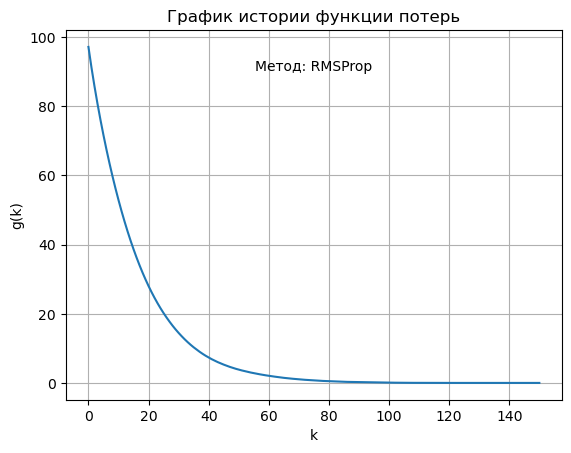

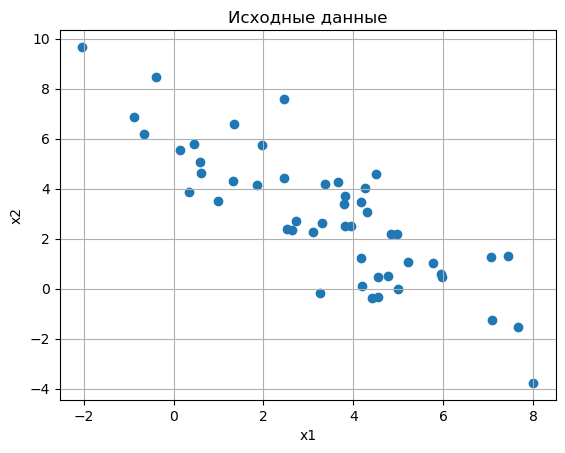

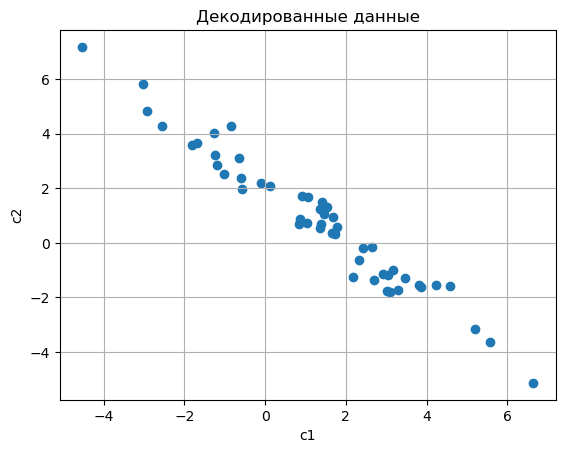

In [5]:
s = Solution_Decoder([[2.0, 1.0], [1.0, 2.0]], x)
s.RMSProp(0.1, 150, 0.8, loss=True)
s.build_true_and_decoded()

# Exercise 8.4. Nonconvexity of the linear Autoencoder

(2, 50)
2


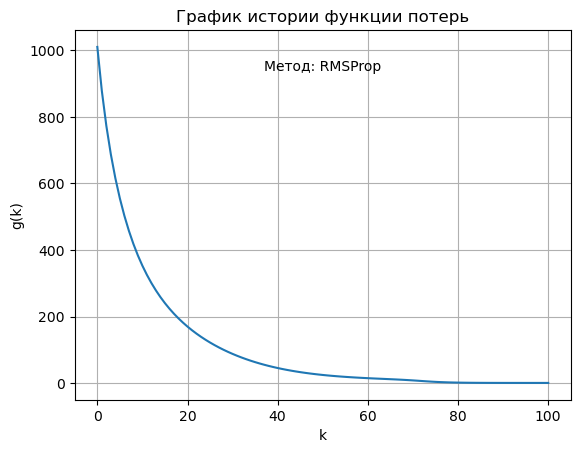

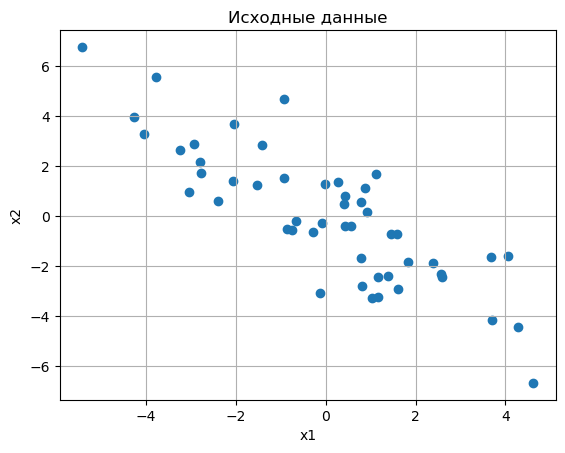

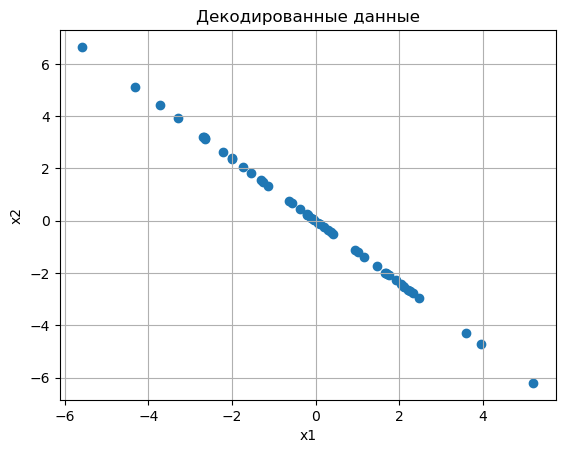

In [6]:
# load in dataset
csvname = datapath + '2d_span_data_centered.csv'
x = np.loadtxt(csvname, delimiter = ',')

print(np.shape(x))
print(len(x))


class Autoencoder:
    def __init__(self, x, k):
        self.C0 = jnp.array(np.random.uniform(low=-5, high=5, size=(len(x), k)))
        self.x = jnp.array(x)
        self.C = None

    def encode(self, C):
        return jnp.dot(C.T, self.x)

    def decode(self, C):
        return jnp.dot(C, self.encode(C))

        

    def MSE(self, C):
        return jnp.mean(jnp.linalg.norm(self.decode(C) - self.x, axis=0)**2)

    def RMSProp(self, d, iter, gamma, loss=False, decreased=False):
        """
        Root Mean Squared Error Propogation - RMSProp
        
        """
        fun = self.MSE
        gradient = grad(fun)
        C0 = self.C0
        C_history = [C0]
        fun_history = [float(fun(C0))]
        C = C0
        for i in range(iter):
            grad_eval = gradient(C)
            if i > 0:
                h = gamma*h + (1 - gamma)*jnp.square(grad_eval)
            else:
                h = jnp.square(grad_eval)
            
            diff = d*grad_eval/jnp.sqrt(h)
            if decreased:
                diff = diff*(1 / (i + 1))
            C = C - diff
            f = fun(C)
            f = float(f)
            C_history.append(C)
            fun_history.append(f)

        self.C = C
        self.C_history = C_history
    
        if loss:
            Solution_Decoder.build_history_of_loss(iter, fun_history, "RMSProp")
    
        return {"min": (C, f), "matrix_history": C_history, "cost_history": fun_history, "iters": iter}

        
    @staticmethod
    def build_history_of_loss(i, fun_list, method_name):
        k = np.linspace(0, i, i+1)
        fun_arr = np.array(fun_list)
        plt.plot(k, fun_arr)
        plt.xlabel('k')
        plt.ylabel('g(k)')
        plt.title('График истории функции потерь')
        plt.text(0.5, 0.9, f'Метод: {method_name}', ha='center', va='center', transform=plt.gca().transAxes)
        plt.grid(True)
        plt.show()

    def build_true_and_decoded(self):
        plt.figure()
        plt.scatter(x[0, :], x[1, :])
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Исходные данные")
        plt.grid(True)
        plt.show()

        decoded = self.decode(self.C)
        x1d, x2d = decoded[0, :], decoded[1, :]
        plt.figure()
        plt.scatter(x1d, x2d)
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Декодированные данные")
        plt.grid(True)
        plt.show()

   




enc = Autoencoder(x, 1)
enc.RMSProp(0.1, 100, 0.9, loss=True)
#print(enc.x)
#print(enc.encode(enc.C))
enc.build_true_and_decoded()
       
#К сожалению, я не разобрался как построить конутрный график, когда есть 3 вектора, он выдаёт ошибку.        

# Exercise 8.5. Minimizing the linear Autoencoder over a toy dataset

(2, 50)


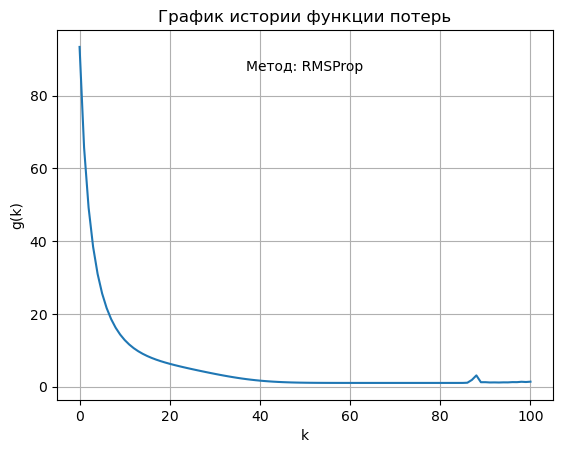

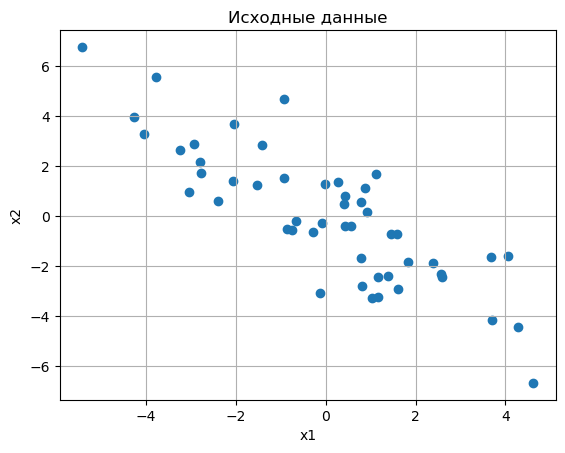

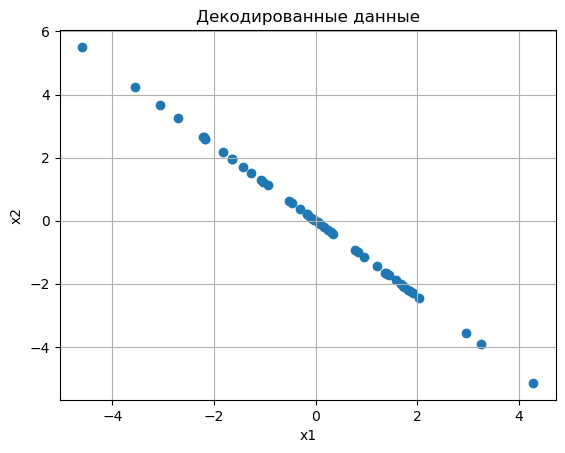

In [7]:
# load in dataset
csvname = datapath + '2d_span_data_centered.csv'
x = np.loadtxt(csvname, delimiter = ',')

print(np.shape(x))
enc = Autoencoder(x, 1)
enc.RMSProp(0.1, 100, 0.9, loss=True)
#print(enc.x)
#print(enc.encode(enc.C))
enc.build_true_and_decoded()

# Exercise 8.6. Producing a PCA basis

(2, 50)


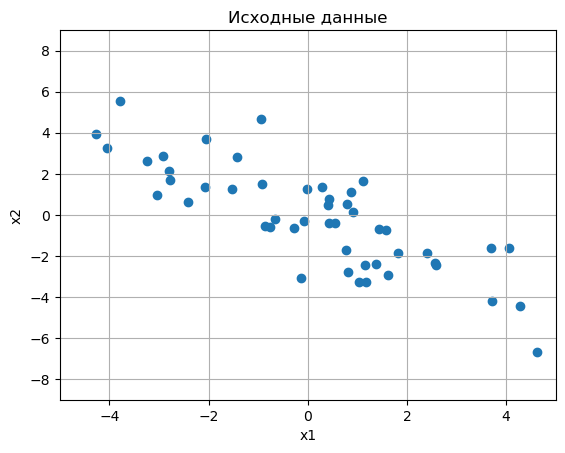

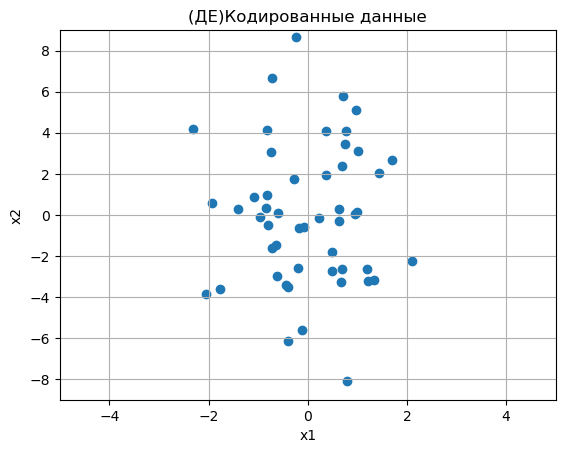

In [61]:
# load in dataset
import autograd.numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt


csvname = datapath + '2d_span_data.csv'
x = np.loadtxt(csvname, delimiter = ',')

print(np.shape(x))


class LinearPCS:
    def __init__(self, x):
        self.x = jnp.array(x)
        self.disp = None
        self.V = None

    def centration(self):
        x_means  = jnp.mean(self.x, axis=1)[:, jnp.newaxis]
        x_centered = self.x - x_means
        return x_centered

    def compute_pcs(self, lam=10e-7):
        X = self.centration()
        P = float(X.shape[1])
        cov = 1/P*jnp.dot(X, X.T) + lam*jnp.eye(self.x.shape[0])

        D,V = jnp.linalg.eigh(cov)
        self.disp, self.V = D, V
        
        return D, V

    def encode(self):
        if self.disp is not None and self.V is not None:
            return jnp.dot(self.centration().T, self.V)

    def decode(self):
        return jnp.dot(self.encode(), self.V.T)

    
    def build_data(self, coded, x1, x2, y1, y2):
        meaned = self.centration()
        plt.figure()
        plt.scatter(meaned[0, :], meaned[1, :])
        plt.xlim(x1, x2)
        plt.ylim(y1, y2)
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Исходные данные")
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.scatter(coded.T[0, :], coded.T[1, :])
        plt.xlim(x1, x2)
        plt.ylim(y1, y2)
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("(ДЕ)Кодированные данные")
        plt.grid(True)
        plt.show()

        
        
        
        
        

sol = LinearPCS(x)
sol.compute_pcs()
encoded = sol.encode()
sol.build_data(encoded, x1=-5, x2=5, y1=-9, y2=9)


        

# Exercise 8.7. A warning example

In [77]:
x_means = jnp.mean(x.T, axis=1)[:, jnp.newaxis]
x.T - x_means

Array([[-0.36706072, -0.25185338, -0.15507919, -0.03987181,  0.03616506,
         0.10068119,  0.1974554 ,  0.27810055,  0.37487477,  0.14215583,
        -0.1665999 , -0.20807457, -0.33249852, -0.24494094, -0.19655383,
        -0.14125428, -0.02835107,  0.05690241,  0.14215583,  0.19515127,
         0.27118808,  0.35183328, -0.01452619],
       [ 0.11556059,  0.08047289,  0.11848456,  0.10971266,  0.10678869,
         0.08339685,  0.08339685,  0.1009407 ,  0.11848456,  0.13310444,
         0.13310444,  0.13310444, -0.11543354, -0.10666162, -0.1592932 ,
        -0.1592932 , -0.09788969, -0.11835754, -0.13590139, -0.13590139,
        -0.05695403, -0.10373765, -0.12712947]], dtype=float32)

(23, 2)
(23,)


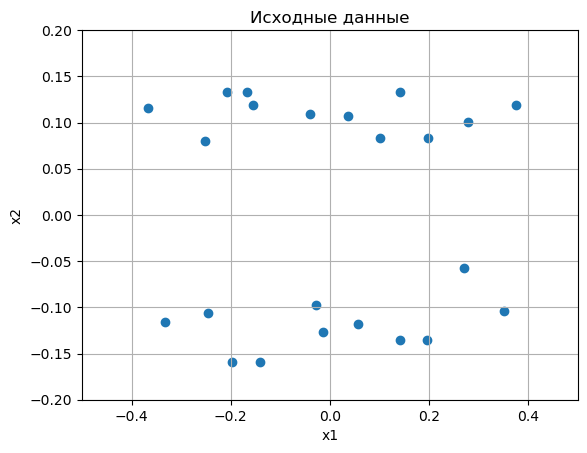

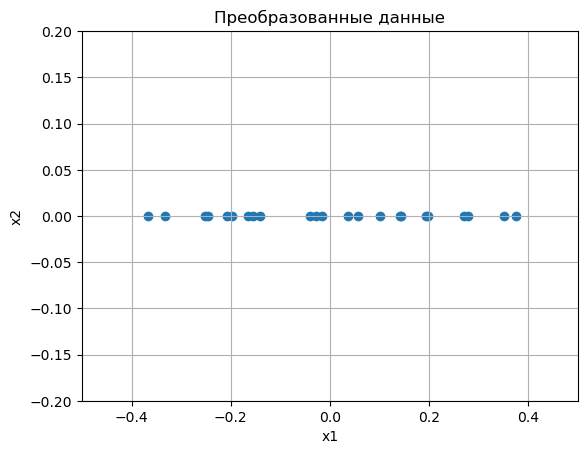

In [80]:
# load in dataset
from sklearn.decomposition import PCA

csvname = datapath + 'PCA_class_data.csv'
data = np.loadtxt(csvname,delimiter = ',');
x = data[:,:2]
y = data[:,-1]

print(np.shape(x))
print(np.shape(y))

pca = PCA(n_components=1) 
x_pca = pca.fit_transform(x)

x_means = jnp.mean(x.T, axis=1)[:, jnp.newaxis]
x_centered = x.T - x_means


plt.figure()
plt.scatter(x_centered[0, :], x_centered[1, :])
plt.xlim(-0.5, 0.5)
plt.ylim(-0.2, 0.2)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Исходные данные")
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(x_pca, jnp.zeros(jnp.shape(x_pca)))
plt.xlim(-0.5, 0.5)
plt.ylim(-0.2, 0.2)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Преобразованные данные")
plt.grid(True)
plt.show()




In [73]:



print(x.T)
x_means = jnp.mean(x.T, axis=0)[:, jnp.newaxis]
print(x - x_means)
print(x_means)

[[0.19470046 0.30990783 0.40668203 0.5218894  0.59792627 0.6624424
  0.75921659 0.83986175 0.93663594 0.70391705 0.39516129 0.35368664
  0.22926267 0.31682028 0.36520737 0.42050691 0.53341014 0.61866359
  0.70391705 0.75691244 0.83294931 0.91359447 0.54723502]
 [0.68859649 0.65350877 0.69152047 0.68274854 0.67982456 0.65643275
  0.65643275 0.67397661 0.69152047 0.70614035 0.70614035 0.70614035
  0.45760234 0.46637427 0.41374269 0.41374269 0.4751462  0.45467836
  0.4371345  0.4371345  0.51608187 0.46929825 0.44590643]]
[[-0.24694802  0.246948  ]
 [-0.17180046  0.1718005 ]
 [-0.14241922  0.14241922]
 [-0.08042961  0.08042955]
 [-0.04094917  0.04094917]
 [ 0.00300485 -0.00300479]
 [ 0.0513919  -0.05139196]
 [ 0.08294261 -0.08294255]
 [ 0.12255776 -0.12255776]
 [-0.00111163  0.00111169]
 [-0.15548953  0.1554895 ]
 [-0.17622685  0.17622685]
 [-0.11416984  0.11416984]
 [-0.07477701  0.07477701]
 [-0.02426767  0.02426764]
 [ 0.00338212 -0.00338212]
 [ 0.02913195 -0.02913198]
 [ 0.08199263 -0.

# Exercise 8.8. Perform K-Means

(2, 50)


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


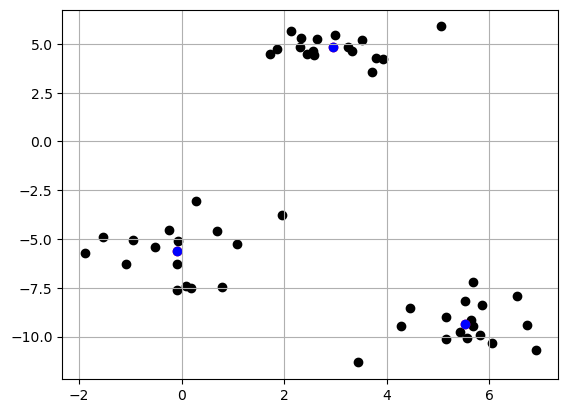

[[ 5.5293348  -9.34360857]
 [ 2.95391082  4.81887725]
 [-0.08772083 -5.618137  ]]
91.00474682033199


In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
import numpy as np
import jax.numpy as jnp
from jax import grad, jit

# Loading the data
P = 50 # Number of data points
blobs = datasets.make_blobs(n_samples=P,centers = 3,random_state=10)
data = np.transpose(blobs[0])
print(data.shape)
# scatter plot the dataset 
plt.scatter(data[0,:],data[1,:],c = 'k')

kmeans = KMeans(n_clusters=3)
kmeans.fit(data.T) 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = "r")
plt.grid(True)


def evolving_kmeans(X, k, max_iters=300):
  centroids = X[np.random.choice(len(X), k)] 
  
  for i in range(max_iters):
    dists = jnp.linalg.norm(X[:,None,:] - centroids[None,:,:], axis=2)**2
    labels = jnp.argmin(dists, axis=1)
    centroids = jnp.stack([X[labels==i].mean(0) for i in range(k)])
    
  return centroids, labels, dists

km = evolving_kmeans(data.T, 3)[0]
plt.scatter(km[:, 0], km[:, 1], c = "b")
plt.show()
print(kmeans.cluster_centers_)
print(kmeans.inertia_)

    

Array(13804.113, dtype=float32)

# Exercise 8.9. Making a scree plot

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

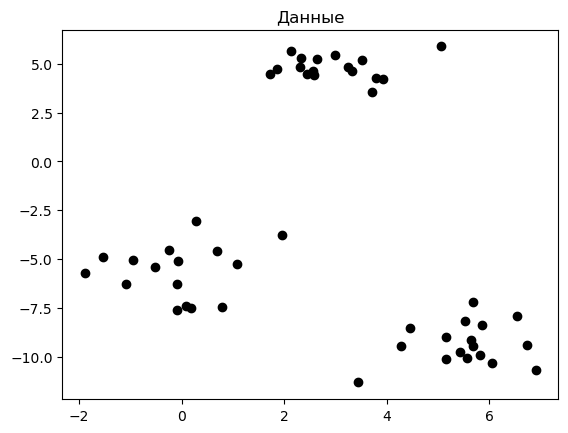

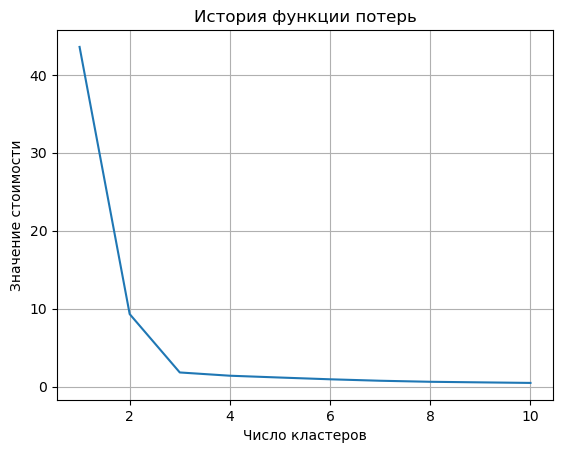

In [143]:
# Loading the data
P = 50 # Number of data points
data = datasets.make_blobs(n_samples=P, random_state=1, centers = 3)
data = np.transpose(blobs[0])
# scatter plot the dataset 
plt.figure()
plt.scatter(data[0,:],data[1,:],c = 'k')
plt.title("Данные")

diffs = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data.T)
    diffs.append(kmeans.inertia_/data.shape[1])
    
    
plt.figure()
plt.plot(np.arange(1, 11), np.array(diffs))
plt.grid(True)
plt.xlabel("Число кластеров")
plt.ylabel("Значение стоимости")
plt.title("История функции потерь")
plt.show()


0.0


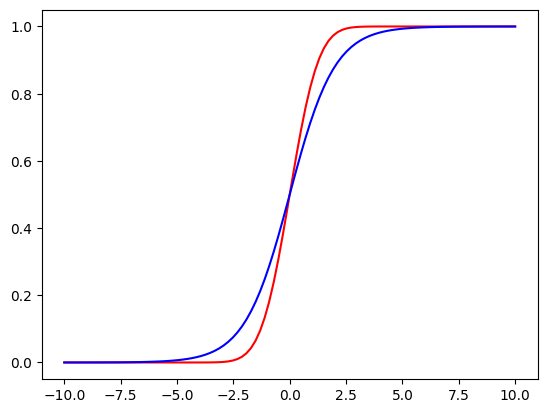

In [11]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np

a = sp.stats.norm.cdf(-100)
print(a)
x = np.linspace(-10, 10, 100)
y1 = sp.stats.norm.cdf(x)
y2 = 1 / (1 + np.exp(-x))
plt.plot(x, y1, c="r")
plt.plot(x, y2, c="b")
plt.show()